In [111]:
#%pip install holidays

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 824.7/824.7 kB 10.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [116]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import holidays
from scipy.stats import ttest_ind

## External Factors and Guest Segmentation

Investigate the influence of external factors such as seasonality or local events on segment size and behavior.
Suggest operational adjustments (e.g., staffing, promotions) for high-impact periods.

## Load Data

This data has been sourced from https://www.kaggle.com/datasets/arushchillar/disneyland-reviews/data and  https://www.kaggle.com/datasets/ayushtankha/hackathon/data?select=waiting_times.csv
The aim of using the attendance data is to see if there are any seasonal trends in terms of popular months, days of weeks and holidays or local events while the disneyland reviews data will be used to explore if there is any relationship between ratings and dates.

The attendance data consists of 2 parks, PortAventura World and Tivoli Gardens from 2018 to 2022.

In [72]:
attendance_data = pd.read_csv("/Users/clarakan/DSA3101/Kaggle/attendance.csv")
print(attendance_data)


      USAGE_DATE       FACILITY_NAME  attendance
0     2018-06-01  PortAventura World       46804
1     2018-06-01      Tivoli Gardens       20420
2     2018-06-02  PortAventura World       57940
3     2018-06-02      Tivoli Gardens       29110
4     2018-06-03  PortAventura World       44365
...          ...                 ...         ...
2362  2022-07-24      Tivoli Gardens       26798
2363  2022-07-25  PortAventura World       53764
2364  2022-07-25      Tivoli Gardens       27061
2365  2022-07-26  PortAventura World       26391
2366  2022-07-26      Tivoli Gardens       14882

[2367 rows x 3 columns]


The Disneyland reviews data consists of reviews from different Disney Lands around the world.

In [133]:
DisneylandReviews_data = pd.read_csv("/Users/clarakan/DSA3101/Kaggle/DisneylandReviews.csv", encoding="latin-1")
print(DisneylandReviews_data.head())

   Review_ID  Rating Year_Month     Reviewer_Location  \
0  670772142       4     2019-4             Australia   
1  670682799       4     2019-5           Philippines   
2  670623270       4     2019-4  United Arab Emirates   
3  670607911       4     2019-4             Australia   
4  670607296       4     2019-4        United Kingdom   

                                         Review_Text               Branch  
0  If you've ever been to Disneyland anywhere you...  Disneyland_HongKong  
1  Its been a while since d last time we visit HK...  Disneyland_HongKong  
2  Thanks God it wasn   t too hot or too humid wh...  Disneyland_HongKong  
3  HK Disneyland is a great compact park. Unfortu...  Disneyland_HongKong  
4  the location is not in the city, took around 1...  Disneyland_HongKong  


## EDA

### Check for null, handle duplicates, clean 

#### Attendance Data


In [95]:
attendance_data.isnull().any()
attendance_data.drop_duplicates(inplace = True)
attendance_data["USAGE_DATE"] = pd.to_datetime(attendance_data["USAGE_DATE"])
attendance_data["Year"] = attendance_data["USAGE_DATE"].dt.year
attendance_data["Month"] = attendance_data["USAGE_DATE"].dt.month
attendance_data["Day_of_Week"] = attendance_data["USAGE_DATE"].dt.day_name()
for x in attendance_data.index:
  if attendance_data.loc[x, "attendance"] < 0:
    attendance_data.loc[x, "attendance"] = 0

attendance_data["mean_attendance"] = attendance_data.groupby(["Year", "FACILITY_NAME"])["attendance"].transform("mean")
attendance_data["std_attendance"] = attendance_data.groupby(["Year", "FACILITY_NAME"])["attendance"].transform("std")

# Standardize attendance
attendance_data["standardized_attendance"] = (attendance_data["attendance"] - attendance_data["mean_attendance"]) / attendance_data["std_attendance"]

attendance_data.head()

,USAGE_DATE,FACILITY_NAME,attendance,Year,Month,Day_of_Week,mean_attendance,std_attendance,standardized_attendance
0,2018-06-01,PortAventura World,46804,2018,6,Friday,45461.004673,13418.682302,0.100084
1,2018-06-01,Tivoli Gardens,20420,2018,6,Friday,22760.574766,7124.590921,-0.328521
2,2018-06-02,PortAventura World,57940,2018,6,Saturday,45461.004673,13418.682302,0.929972
3,2018-06-02,Tivoli Gardens,29110,2018,6,Saturday,22760.574766,7124.590921,0.891199
4,2018-06-03,PortAventura World,44365,2018,6,Sunday,45461.004673,13418.682302,-0.081678


#### Disneyland Reviews Data

In [138]:
print(DisneylandReviews_data["Year_Month"].unique())  # Check all unique values
print(DisneylandReviews_data["Year_Month"].isnull().sum())  # Count NaNs
DisneylandReviews_data = DisneylandReviews_data.dropna(subset=["Year_Month"])  # Remove rows with missing dates

DisneylandReviews_data["Year_Month"] = pd.to_datetime(
    DisneylandReviews_data["Year_Month"], format="%Y-%m", errors="coerce"
)
DisneylandReviews_data["Year"] = DisneylandReviews_data["Year_Month"].dt.year
DisneylandReviews_data["Month"] = DisneylandReviews_data["Year_Month"].dt.month
DisneylandReviews_data.head()

<DatetimeArray>
['2019-04-01 00:00:00', '2019-05-01 00:00:00', '2019-03-01 00:00:00',
 '2018-09-01 00:00:00', '2019-01-01 00:00:00', '2018-11-01 00:00:00',
 '2018-12-01 00:00:00', '2018-06-01 00:00:00', '2019-02-01 00:00:00',
 '2018-10-01 00:00:00',
 ...
 '2010-12-01 00:00:00', '2010-11-01 00:00:00', '2010-10-01 00:00:00',
 '2010-09-01 00:00:00', '2010-05-01 00:00:00', '2010-03-01 00:00:00',
 '2010-08-01 00:00:00', '2010-07-01 00:00:00', '2010-06-01 00:00:00',
 '2010-04-01 00:00:00']
Length: 111, dtype: datetime64[ns]
0


,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch,Year,Month
0,670772142,4,2019-04-01,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,2019,4
1,670682799,4,2019-05-01,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,2019,5
2,670623270,4,2019-04-01,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,2019,4
3,670607911,4,2019-04-01,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,2019,4
4,670607296,4,2019-04-01,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,2019,4


### Plotting graphs

#### Attendance Data

There is missing data for 2021-01 and the covid-19 pandemic which started in March 2020 and ended in May 2023 affected those data within that yeear

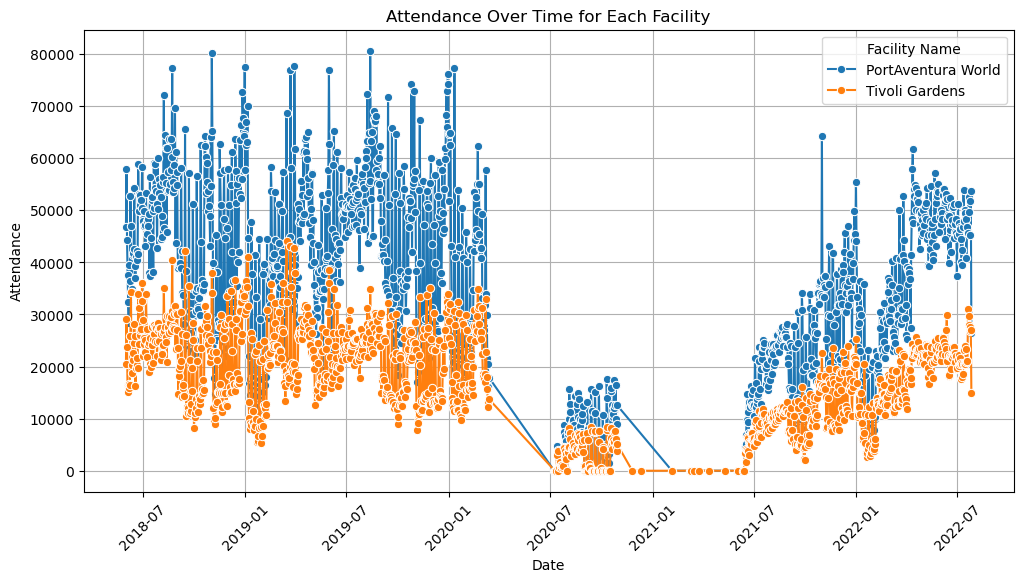

In [92]:
#attendance_data["USAGE_DATE"] = pd.to_datetime(attendance_data["USAGE_DATE"])

# Set up the plot
plt.figure(figsize=(12, 6))

# Plot attendance over time for each facility
sns.lineplot(data=attendance_data, x="USAGE_DATE", y="attendance", hue="FACILITY_NAME", marker="o")

# Beautify the plot
plt.xlabel("Date")
plt.ylabel("Attendance")
plt.title("Attendance Over Time for Each Facility")
plt.xticks(rotation=45)
plt.legend(title="Facility Name")
plt.grid(True)

# Show the plot
plt.show()

#### Monthly Trend for each year
both attendance follows the same trend roughly.

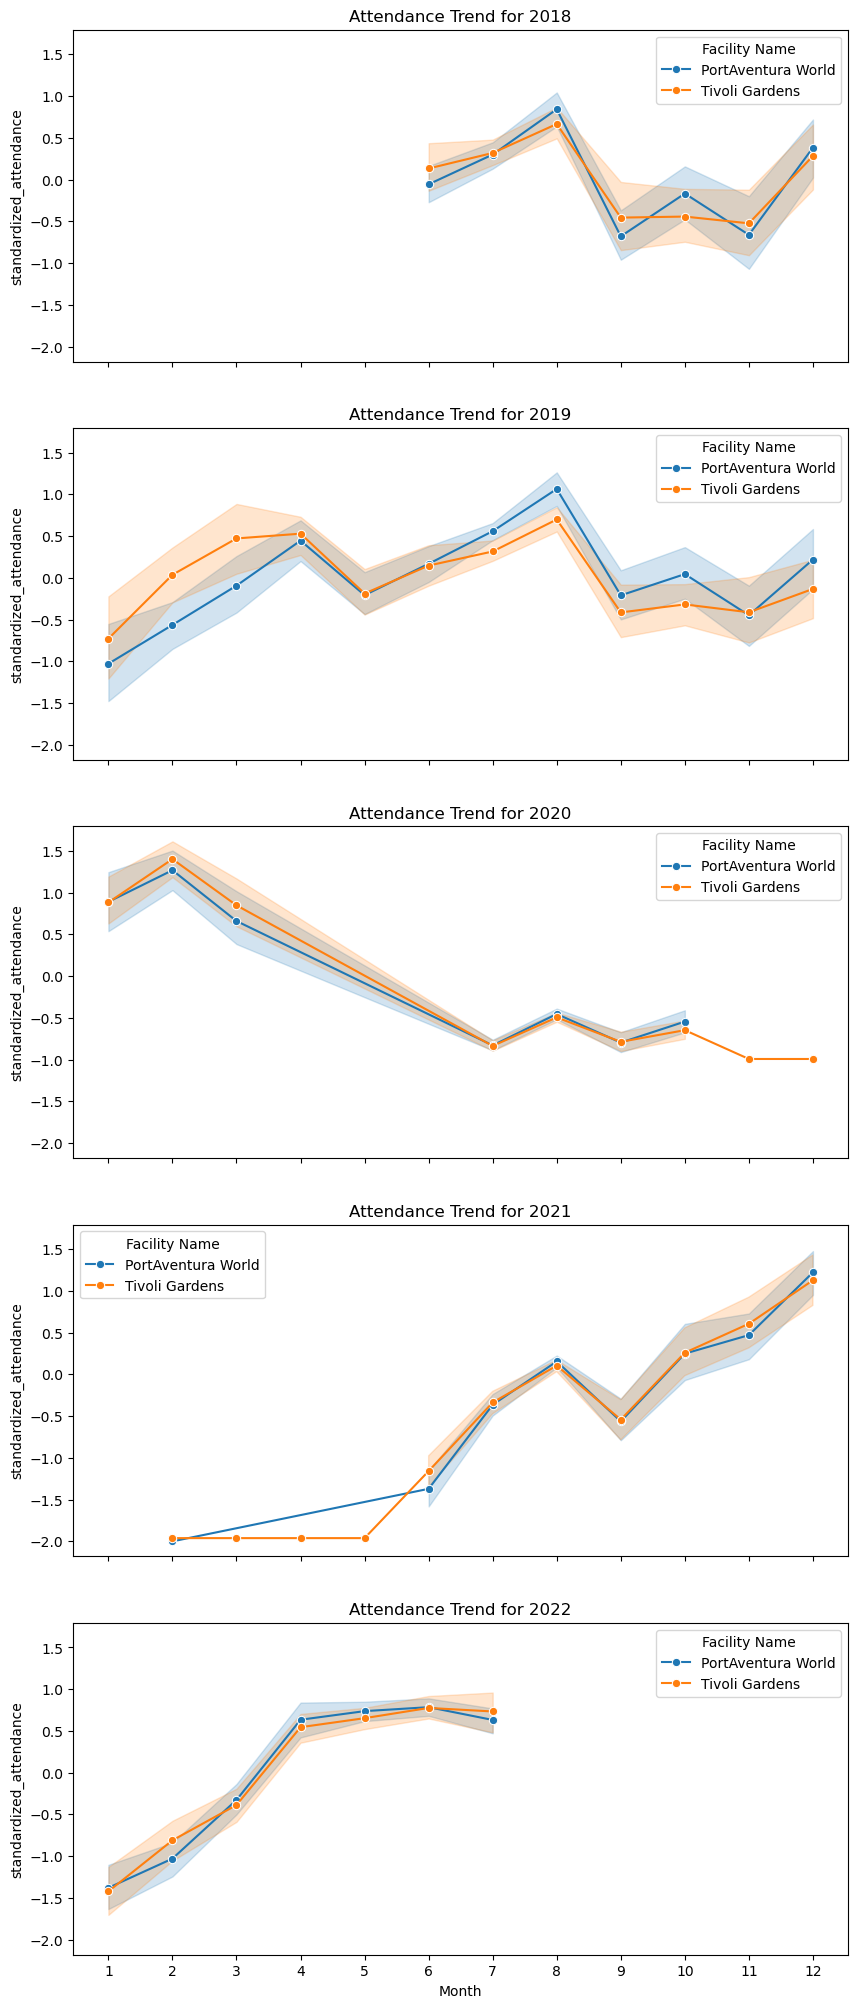

In [100]:
#attendance_data["Year"] = attendance_data["USAGE_DATE"].dt.year
#attendance_data["Month"] = attendance_data["USAGE_DATE"].dt.month
attendance_data.head()

#monthly_facility_mean = attendance_data.groupby(["Year", "Month", "FACILITY_NAME"])["attendance"].mean().reset_index()
unique_years = monthly_facility_mean["Year"].unique()
num_years = len(unique_years)

fig, axes = plt.subplots(num_years, 1, figsize=(10, 5 * num_years), sharex=True, sharey=True)

# Ensure axes is iterable even if there's only one year
if num_years == 1:
    axes = [axes]

# Plot each year separately
for i, year in enumerate(sorted(unique_years)):
    ax = axes[i]
    subset = attendance_data[attendance_data["Year"] == year]  # Filter data for the current year
    
    sns.lineplot(data=subset, x="Month", y="standardized_attendance", hue="FACILITY_NAME", marker="o", ax=ax)
    
    ax.set_title(f"Attendance Trend for {year}")
    ax.set_xticks(range(1, 13))  # Ensure all months 1-12 appear on x-axis
    ax.set_xlabel("Month")
    ax.set_ylabel("standardized_attendance")
    ax.legend(title="Facility Name")
    

plt.show()

#### Daily trend
Saturday has the most number of people visiting theme parks

   USAGE_DATE     FACILITY_NAME_x  attendance  Year  Month Day_of_Week  \
0  2018-06-23  PortAventura World       58821  2018      6    Saturday   
1  2018-06-30      Tivoli Gardens       36005  2018      6    Saturday   
2  2018-07-07      Tivoli Gardens       33899  2018      7    Saturday   
3  2018-07-28  PortAventura World       60031  2018      7    Saturday   
4  2018-08-23  PortAventura World       77261  2018      8    Thursday   
..        ...                 ...         ...   ...    ...         ...   
88 2022-05-28      Tivoli Gardens       25426  2022      5    Saturday   
89 2022-06-07  PortAventura World       54167  2022      6     Tuesday   
90 2022-06-12      Tivoli Gardens       29936  2022      6      Sunday   
91 2022-07-12  PortAventura World       53867  2022      7     Tuesday   
92 2022-07-20      Tivoli Gardens       30987  2022      7   Wednesday   

    mean_attendance  std_attendance  standardized_attendance  \
0      45461.004673    13418.682302            

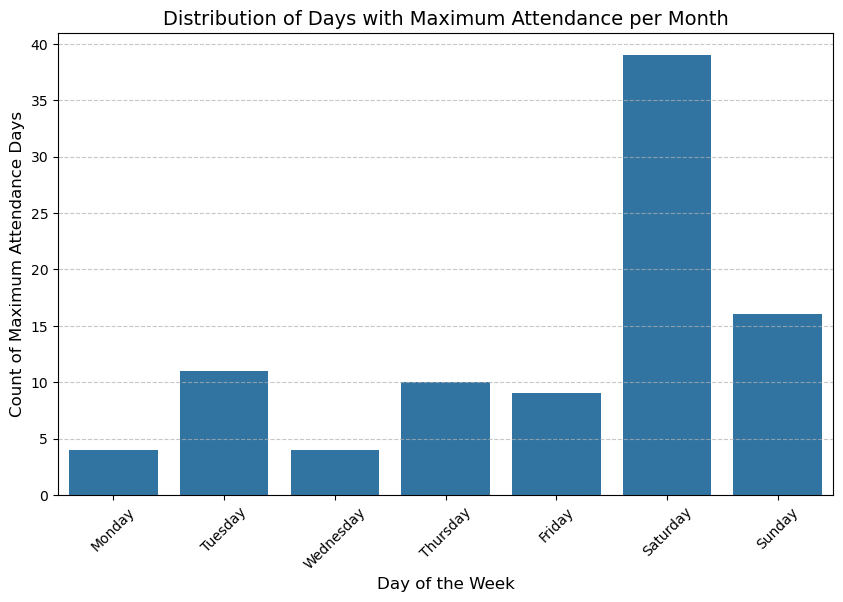

In [106]:
attendance_data.head()
# Group by Year and Month, then find the maximum attendance
max_attendance_per_month = attendance_data.groupby(["Year", "Month", "FACILITY_NAME"])["attendance"].max().reset_index()
max_attendance_dates =  attendance_data.merge(max_attendance_per_month, on=["Year", "Month", "attendance"], how="inner")

# Display the result
print(max_attendance_dates)

#plot day distribution
# Count occurrences of each day in the max attendance dataset
plt.figure(figsize=(10, 6))
sns.countplot(data=max_attendance_dates, x="Day_of_Week", order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

# Customize the plot
plt.xlabel("Day of the Week", fontsize=12)
plt.ylabel("Count of Maximum Attendance Days", fontsize=12)
plt.title("Distribution of Days with Maximum Attendance per Month", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()



#### Local events and holidays
Attendance on holidays are higher than on non-holidays. Holidays such as Christmas and New Years are more popular times where people go to the parks.

In [109]:
#PortAventura World
portaventura_df = attendance_data[attendance_data["FACILITY_NAME"] == "PortAventura World"]

#Tivoli Gardens	
tivoli_df = attendance_data[attendance_data["FACILITY_NAME"] == "Tivoli Gardens"]

##### PortAventura World (Spain)

Average attendance on holidays: 43767.57692307692
Average attendance on non-holidays: 34741.14273356401
T-statistic: 2.799057438576239, P-value: 0.009453542443116381


/var/folders/xy/mxl2xzz57lgg3w741xs6sb800000gn/T/ipykernel_13191/3214050399.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portaventura_df["is_holiday"] = portaventura_df["USAGE_DATE"].apply(lambda x: x in spain_holidays)


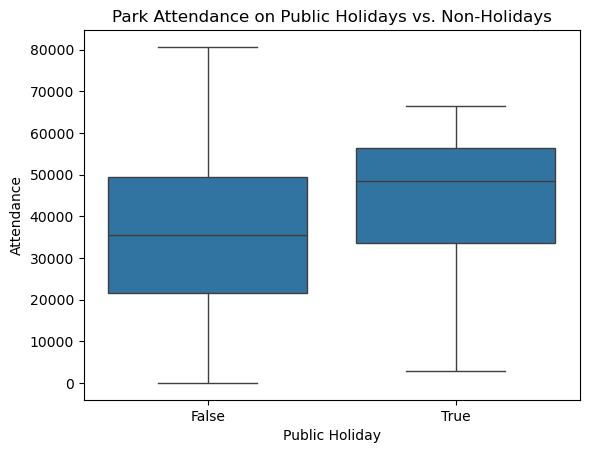

In [119]:
spain_holidays = holidays.Spain(years=[2018, 2019, 2020, 2021, 2022])
portaventura_df["is_holiday"] = portaventura_df["USAGE_DATE"].apply(lambda x: x in spain_holidays)

#Check average attendance on holidays
holiday_attendance = portaventura_df[portaventura_df["is_holiday"] == True]["attendance"].mean()
non_holiday_attendance = portaventura_df[portaventura_df["is_holiday"] == False]["attendance"].mean()

print(f"Average attendance on holidays: {holiday_attendance}")
print(f"Average attendance on non-holidays: {non_holiday_attendance}")

#Use T-test and p value to see if it is statistically significant
holiday_values = portaventura_df[portaventura_df["is_holiday"] == True]["attendance"]
non_holiday_values = portaventura_df[portaventura_df["is_holiday"] == False]["attendance"]

t_stat, p_value = ttest_ind(holiday_values, non_holiday_values, equal_var=False)

print(f"T-statistic: {t_stat}, P-value: {p_value}") #p-value less than 0.05, statistically significant

#Plot
sns.boxplot(x=portaventura_df["is_holiday"], y=portaventura_df["attendance"])
plt.xlabel("Public Holiday")
plt.ylabel("Attendance")
plt.title("Park Attendance on Public Holidays vs. Non-Holidays")
plt.show()


     holiday_name    attendance
0   Christmas Day  56117.666667
1        Epiphany  34882.000000
2       Labor Day  51284.000000
3  New Year's Day  51201.333333
4     Non-Holiday  34816.009394


/var/folders/xy/mxl2xzz57lgg3w741xs6sb800000gn/T/ipykernel_13191/1233065620.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portaventura_df["holiday_name"] = portaventura_df["USAGE_DATE"].apply(get_holiday)
/var/folders/xy/mxl2xzz57lgg3w741xs6sb800000gn/T/ipykernel_13191/1233065620.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=holiday_attendance, x="holiday_name", y="attendance", palette="viridis")


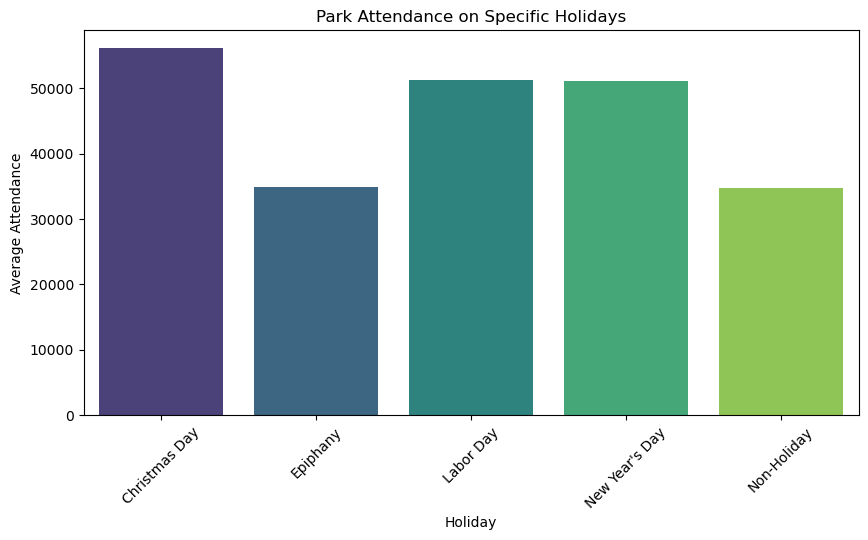

In [126]:
#Check to see if some holidays affected more

spain_holidays = holidays.Spain(years=portaventura_df["Year"].unique())

# Select specific major holidays
key_holidays = {
    "New Year's Day": "01-01",
    "Epiphany": "01-06",
    "Easter Sunday": "variable",
    "Labor Day": "05-01",
    "Christmas Day": "12-25"
}

# Convert variable holidays like Easter Sunday
key_holidays["Easter Sunday"] = [date for date in spain_holidays if "Easter Sunday" in spain_holidays.get(date)]

def get_holiday(date):
    date_str = date.strftime("%m-%d")
    for holiday, value in key_holidays.items():
        if isinstance(value, list) and date in value:
            return holiday
        elif date_str == value:
            return holiday
    return "Non-Holiday"

portaventura_df["holiday_name"] = portaventura_df["USAGE_DATE"].apply(get_holiday)

holiday_attendance = portaventura_df.groupby("holiday_name")["attendance"].mean().reset_index()
print(holiday_attendance)

#Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=holiday_attendance, x="holiday_name", y="attendance", palette="viridis")

plt.xlabel("Holiday")
plt.ylabel("Average Attendance")
plt.title("Park Attendance on Specific Holidays")
plt.xticks(rotation=45)
plt.show()

##### Tivoli Garden (Denmark)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
Average attendance on holidays: 25439.96
Average attendance on non-holidays: 17170.93017241379
T-statistic: 8.228205089324502, P-value: 6.415605888443691e-09


/var/folders/xy/mxl2xzz57lgg3w741xs6sb800000gn/T/ipykernel_13191/1245891564.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tivoli_df["is_holiday"] = tivoli_df["USAGE_DATE"].apply(lambda x: x in denmark_holidays)


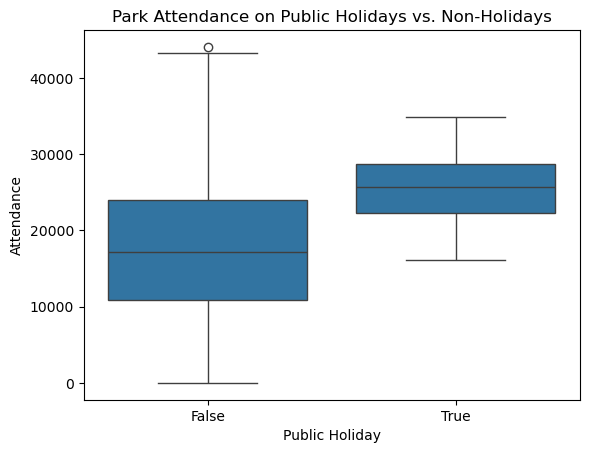

In [122]:
denmark_holidays = holidays.Denmark(years=[2018, 2019, 2020, 2021, 2022])
tivoli_df["is_holiday"] = tivoli_df["USAGE_DATE"].apply(lambda x: x in denmark_holidays)

#Check average attendance on holidays
holiday_attendance = tivoli_df[tivoli_df["is_holiday"] == True]["attendance"].mean()
non_holiday_attendance = tivoli_df[tivoli_df["is_holiday"] == False]["attendance"].mean()

print(f"Average attendance on holidays: {holiday_attendance}")
print(f"Average attendance on non-holidays: {non_holiday_attendance}")

#Use T-test and p value to see if it is statistically significant
holiday_values = tivoli_df[tivoli_df["is_holiday"] == True]["attendance"]
non_holiday_values = tivoli_df[tivoli_df["is_holiday"] == False]["attendance"]

t_stat, p_value = ttest_ind(holiday_values, non_holiday_values, equal_var=False)

print(f"T-statistic: {t_stat}, P-value: {p_value}") #p-value less than 0.05, statistically significant

#Plot
sns.boxplot(x=tivoli_df["is_holiday"], y=tivoli_df["attendance"])
plt.xlabel("Public Holiday")
plt.ylabel("Attendance")
plt.title("Park Attendance on Public Holidays vs. Non-Holidays")
plt.show()


       holiday_name    attendance
0        Boxing Day  23494.666667
1     Christmas Day  25168.000000
2     Christmas Eve  18326.333333
3  Constitution Day  19674.333333
4    New Year's Day  25386.333333
5       Non-Holiday  17280.452137


/var/folders/xy/mxl2xzz57lgg3w741xs6sb800000gn/T/ipykernel_13191/3146966411.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tivoli_df["holiday_name"] = tivoli_df["USAGE_DATE"].apply(get_holiday)
/var/folders/xy/mxl2xzz57lgg3w741xs6sb800000gn/T/ipykernel_13191/3146966411.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=holiday_attendance, x="holiday_name", y="attendance", palette="viridis")


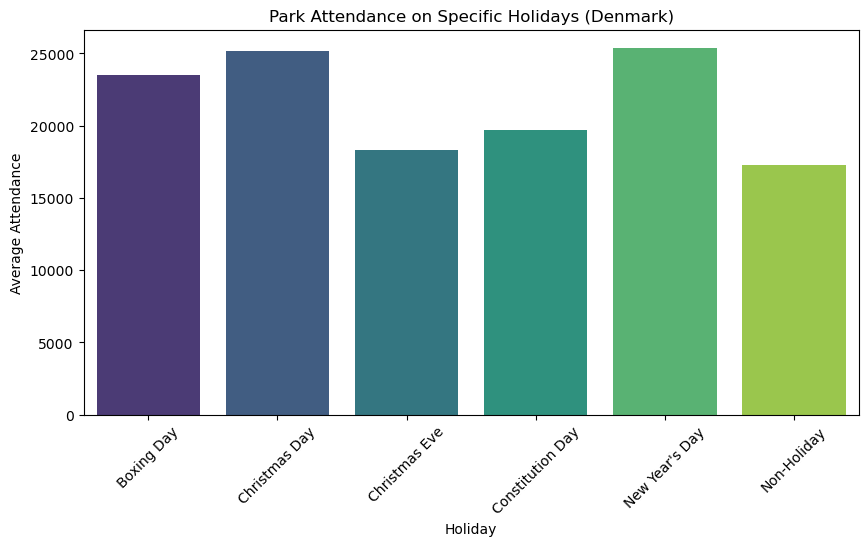

In [129]:
#Check to see if some holidays affected more

denmark_holidays = holidays.Denmark(years=tivoli_df["Year"].unique())

# Select specific major holidays
key_holidays = {
    "New Year's Day": "01-01",
    "Easter Sunday": "variable",
    "Great Prayer Day": "variable",
    "Ascension Day": "variable",
    "Constitution Day": "06-05",
    "Christmas Eve": "12-24",
    "Christmas Day": "12-25",
    "Boxing Day": "12-26"
}

# Convert variable holidays (e.g., Easter Sunday, Great Prayer Day)
variable_holidays = {}

for date, name in denmark_holidays.items():
    holiday_name = str(name)  # Convert holiday name to a string
    if any(h in holiday_name for h in ["Easter", "Great Prayer", "Ascension"]):
        variable_holidays[holiday_name] = date

# Add variable holidays to key_holidays
key_holidays.update(variable_holidays)

def get_holiday(date):
    date_str = date.strftime("%m-%d")
    for holiday, value in key_holidays.items():
        if isinstance(value, list) and date in value:
            return holiday
        elif date_str == value:
            return holiday
    return "Non-Holiday"

tivoli_df["holiday_name"] = tivoli_df["USAGE_DATE"].apply(get_holiday)

holiday_attendance = tivoli_df.groupby("holiday_name")["attendance"].mean().reset_index()
print(holiday_attendance)

plt.figure(figsize=(10, 5))
sns.barplot(data=holiday_attendance, x="holiday_name", y="attendance", palette="viridis")

plt.xlabel("Holiday")
plt.ylabel("Average Attendance")
plt.title("Park Attendance on Specific Holidays (Denmark)")
plt.xticks(rotation=45)
plt.show()


#### DisneyLand Reviews

    Month    Rating
0       1  4.292528
1       2  4.204961
2       3  4.215380
3       4  4.201553
4       5  4.232335
5       6  4.194150
6       7  4.213402
7       8  4.115423
8       9  4.362229
9      10  4.239373
10     11  4.324395
11     12  4.235157


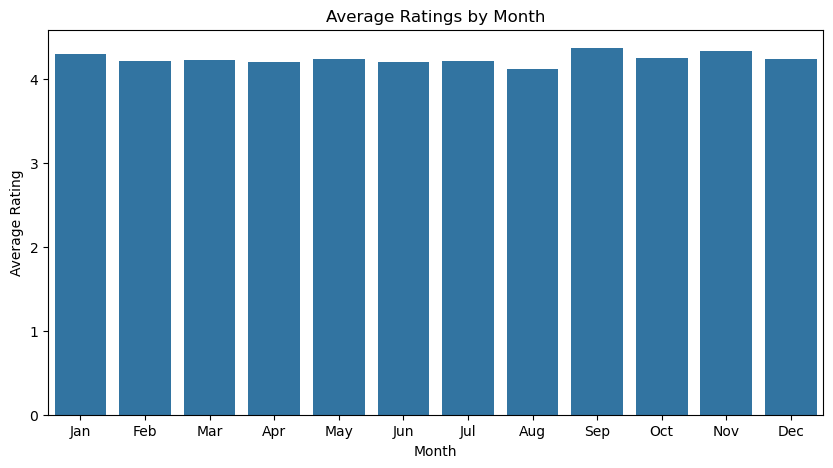

In [144]:
#See if there are some months which have better ratings in general
monthly_ratings = DisneylandReviews_data.groupby("Month")["Rating"].mean().reset_index()
print(monthly_ratings)

plt.figure(figsize=(10, 5))
sns.barplot(x=monthly_ratings["Month"], y=monthly_ratings["Rating"])

plt.xlabel("Month")
plt.ylabel("Average Rating")
plt.title("Average Ratings by Month")
plt.xticks(range(12), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.show()


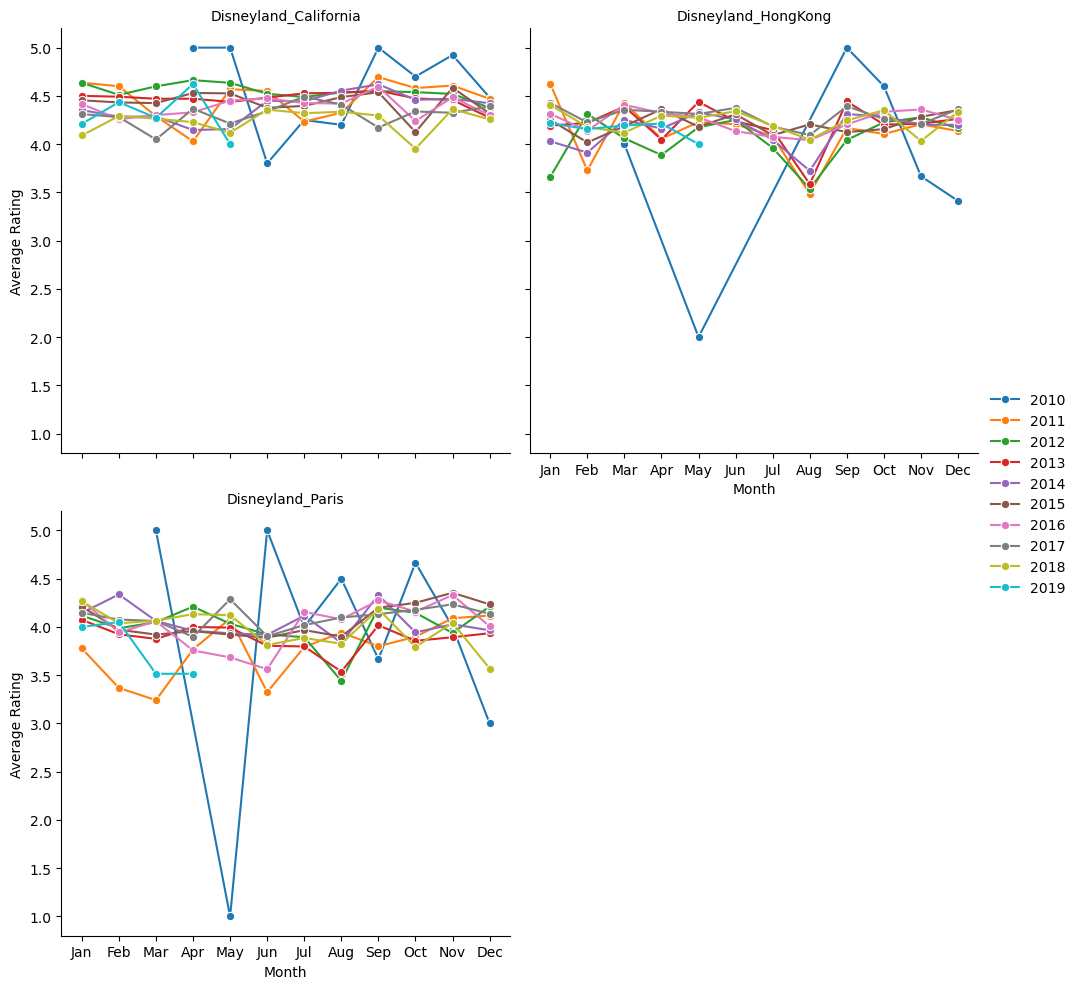

In [146]:
#Check year and month
ratings_trend = DisneylandReviews_data.groupby(["Branch", "Year", "Month"])["Rating"].mean().reset_index()

g = sns.FacetGrid(ratings_trend, col="Branch", col_wrap=2, height=5, sharey=True)
g.map_dataframe(sns.lineplot, x="Month", y="Rating", hue="Year", marker="o", palette="tab10")

g.set_axis_labels("Month", "Average Rating")
g.set_titles("{col_name}")  # Set branch name as title
g.add_legend()

plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.show()


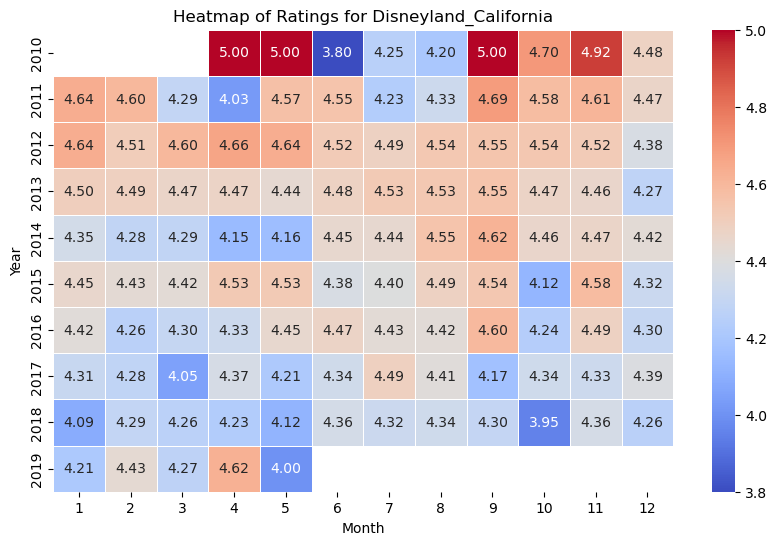

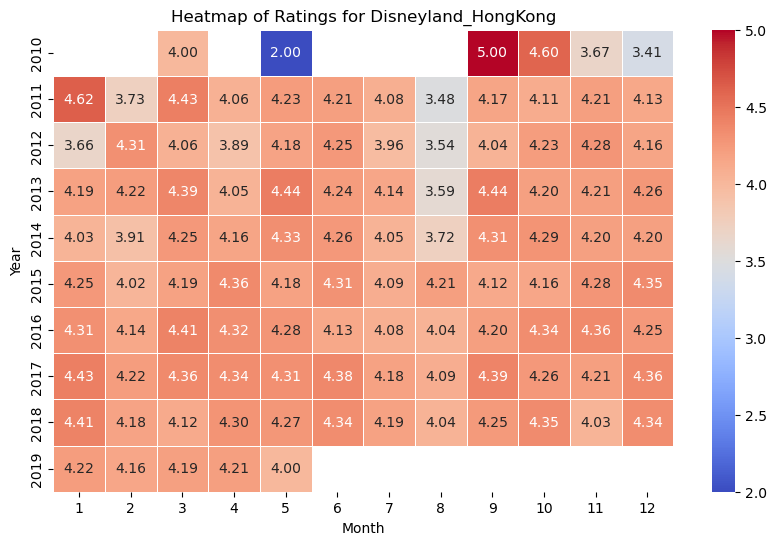

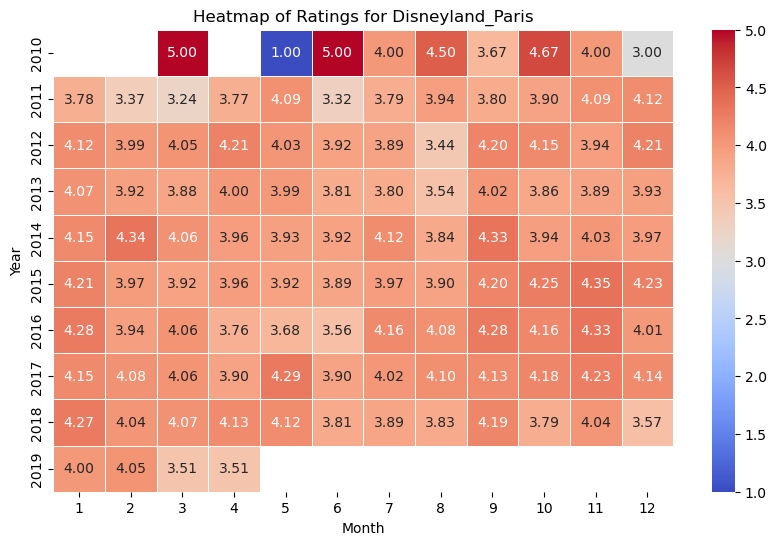

In [147]:
branches = ratings_trend["Branch"].unique()

for branch in branches:
    plt.figure(figsize=(10, 6))
    branch_data = ratings_trend[ratings_trend["Branch"] == branch].pivot(index="Year", columns="Month", values="Rating")

    sns.heatmap(branch_data, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
    
    plt.xlabel("Month")
    plt.ylabel("Year")
    plt.title(f"Heatmap of Ratings for {branch}")
    plt.show()
